In [1]:
%matplotlib inline
import csv
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

TRAIN_FILE_PATH = "data/X_train.csv"
TARGET_FILE_PATH =  "data/y_train.csv"
TEST_FILE_PATH = "data/X_test.csv"

In [17]:
#Load train and test set
print("\nTrain Data\n")

train_data = pd.read_csv(TRAIN_FILE_PATH)
train_data.drop(train_data.columns[0], axis=1, inplace=True)

Y_train = pd.read_csv(TARGET_FILE_PATH)
Y_train.drop(Y_train.columns[0], axis=1, inplace = True)

print("\nTest Data\n")

test_data =  pd.read_csv(TEST_FILE_PATH)
id_test = test_data.columns[0]
#test_data.drop(test_data.columns[0], axis=1, inplace=True)


Train Data


Test Data



In [8]:
# fill missing values with mean column values train and test set
def fill_NaN(train, test):
    print("Train shape: ", train.shape)
    print("Test shape: ",test.shape)
    train_mean_values = train.mean()
    train =  train.fillna(train_mean_values)
    test = test.fillna(train_mean_values)
    
    return train,test


In [9]:
train_data_mean, test_data_mean = fill_NaN(train_data, test_data)

Train shape:  (1212, 887)
Test shape:  (776, 887)


In [10]:
#Zero mean unit variance for train and test data
def scale_data(train, test):
    
    print("Train shape: ", train.shape)
    print("Test shape: ",test.shape)
    scaler = StandardScaler().fit(train, Y_train)
    #print(train_data_mean.shape)
    #print(test_data_mean.shape)
    train = scaler.transform(train)
    test = scaler.transform(test)
   
    return train, test

In [12]:
X_train_scaled, X_test_scaled = scale_data(train_data_mean, test_data_mean)

Train shape:  (1212, 887)
Test shape:  (776, 887)


(1212, 887)
(1212, 1)
[3.17463281e+02 3.09312060e+02 3.07583691e+02 2.85601310e+02
 2.78761802e+02 2.78148971e+02 2.73253960e+02 2.52760516e+02
 2.43972974e+02 2.43891857e+02 2.42925703e+02 2.38413283e+02
 2.00450421e+02 1.88501078e+02 1.87394892e+02 1.85534631e+02
 1.83031939e+02 1.77067457e+02 1.73985580e+02 1.72904968e+02
 1.63621244e+02 1.59121648e+02 1.58715436e+02 1.58235651e+02
 1.58076335e+02 1.54792017e+02 1.51246158e+02 1.50905309e+02
 1.50059132e+02 1.44974863e+02 1.41936780e+02 1.41853063e+02
 1.38327690e+02 1.37595239e+02 1.36981311e+02 1.33495247e+02
 1.29886104e+02 1.27973959e+02 1.27868471e+02 1.27800779e+02
 1.23643847e+02 1.21575634e+02 1.19960216e+02 1.17397751e+02
 1.16924717e+02 1.16108916e+02 1.15126528e+02 1.14374064e+02
 1.12846943e+02 1.11589434e+02 1.11331764e+02 1.09974839e+02
 1.08125510e+02 1.05072321e+02 1.01706441e+02 9.78253813e+01
 9.36728322e+01 9.31268014e+01 9.19324055e+01 8.80093999e+01
 8.72718824e+01 8.72661510e+01 8.71275443e+01 8.69762456e+01
 8

/home/francesco/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/francesco/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/francesco/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/francesco/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/francesco/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & 

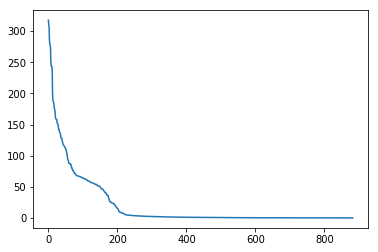

In [13]:
#Extract the features to use

n_features_fr = 150

print(X_train_scaled.shape)
print(Y_train.shape)
features_scores = f_regression(X_train_scaled,Y_train)[0]
#print(features_scores)
y = list(features_scores)
myarray = np.asarray(y)
print(-1*np.sort(-1*myarray))
#print(-1*np.sort(myarray-1))
plt.plot(-1*np.sort(-1*myarray))

indices_fr = myarray.argsort()[-n_features_fr:][::-1]
print(indices_fr)
print(len(indices_fr))



/home/francesco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50building tree 23 of 50

building tree 24 of 50


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.7s


building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.0s finished


[2.15501008e-01 9.29974616e-02 4.99392495e-02 2.71609113e-02
 1.73485968e-02 1.57639612e-02 1.45749174e-02 1.39622131e-02
 9.04134003e-03 7.67304906e-03 7.41005656e-03 5.23657938e-03
 5.14586204e-03 5.10144659e-03 4.80616193e-03 4.46406805e-03
 3.83844505e-03 3.74489457e-03 3.74332515e-03 3.66985326e-03
 3.61887523e-03 3.39157712e-03 3.29001775e-03 3.10461731e-03
 3.08089577e-03 2.89591512e-03 2.88675241e-03 2.84148952e-03
 2.72235554e-03 2.71378756e-03 2.62381630e-03 2.52650094e-03
 2.51591056e-03 2.48724809e-03 2.34451375e-03 2.33019619e-03
 2.26657507e-03 2.24599885e-03 2.23050747e-03 2.18939548e-03
 2.17140288e-03 2.15548367e-03 2.11155977e-03 2.06492280e-03
 2.05613904e-03 2.01143010e-03 2.00706708e-03 1.98210901e-03
 1.97512167e-03 1.94427194e-03 1.88701709e-03 1.88309240e-03
 1.88039503e-03 1.87422349e-03 1.82667568e-03 1.82616189e-03
 1.81604847e-03 1.81554964e-03 1.80975080e-03 1.76541971e-03
 1.75414319e-03 1.74411987e-03 1.71346625e-03 1.70963390e-03
 1.69054840e-03 1.686718

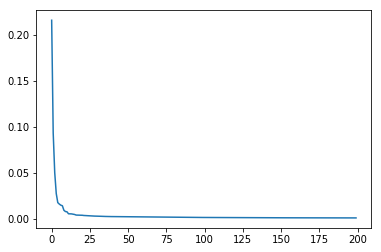

In [14]:
#Extract feature importance of Random Forest & find intersection with f_regression one

n_features_rf = 100

rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=3)
rf.fit(X_train_scaled,Y_train)

scores = list(rf.feature_importances_)
my_rf_features = np.asarray(scores)
print(-1*np.sort(-1*my_rf_features))
#print(-1*np.sort(myarray-1))
plt.plot((-1*np.sort(-1*my_rf_features))[0:200])

indices_rf = my_rf_features.argsort()[-n_features_rf:][::-1]
print(indices_rf)
#print(-1*np.sort(-1*rf.feature_importances_));


In [15]:
# Find intersection between best f_regression features and random forest's

#print(set(indices_rf).intersection(indices_fr))

#indices = set(indices_rf).intersection(indices_fr)
indices = np.union1d(indices_rf, indices_fr)
print(indices)

[  0   5   7  15  20  28  32  42  49  52  53  66  80  82  83  85  88  89
  94  96 111 120 135 137 140 142 151 156 158 162 166 173 178 180 185 186
 192 196 198 200 201 205 209 224 229 232 234 237 251 264 266 269 273 275
 277 279 280 283 290 291 297 298 299 300 309 320 326 332 333 335 336 340
 345 349 350 351 363 367 369 370 371 372 374 388 391 398 400 424 426 428
 430 444 449 450 457 460 470 479 484 490 493 497 499 504 505 520 523 529
 539 546 547 554 555 556 560 591 599 604 605 607 608 609 611 613 615 618
 632 633 634 636 637 638 643 644 646 651 652 660 664 665 666 673 685 686
 687 697 716 722 730 731 735 736 737 739 741 744 746 751 752 763 772 781
 787 791 794 795 799 804 810 811 816 823 829 833 838 840 844 853 870 871
 873 879 882]


In [16]:
#Extract the feature selected from dataset

#indices = indices_rf
#indices = indices_fr
indices = list(indices)

X_train_subset = train_data_mean[train_data_mean.columns[indices]]
X_test_subset = test_data_mean[train_data_mean.columns[indices]]

#print(X_subset.head(1))

X_train_subset, X_test_subset = fill_NaN(X_train_subset, X_test_subset)
X_train_subset, X_test_subset = scale_data(X_train_subset, X_test_subset)

print(X_train_subset.shape)

Train shape:  (1212, 183)
Test shape:  (776, 183)
Train shape:  (1212, 183)
Test shape:  (776, 183)
(1212, 183)


In [127]:
#y_pred = model.predict(X_test_subset)
test_data["y"] = predictions
#print(y_pred)

In [128]:
# create submission
test_data[["id", "y"]].to_csv("submissions/keras_deep_dropout_regul_0.70_wide80.csv", index= False)

In [208]:
y_pred = model.predict(X_train_subset)
from sklearn.metrics import r2_score
score = r2_score(Y, y_pred)
print(score)

0.47870539796991196


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.optimizers import Adam
from keras.layers import Dropout
from keras import regularizers
from keras import initializers
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
# fix random seed for reproducibility

def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

initializer = initializers.glorot_normal(seed=1)
lambda_reg = 2
Y = Y_train
dropout = 0.1
#print(Y)
# create model
model = Sequential()
model.add(Dense(80, input_dim=178, kernel_regularizer = regularizers.l2(lambda_reg), init=initializer))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate = dropout))
model.add(Dense(80, input_dim=72, kernel_regularizer = regularizers.l2(lambda_reg), init=initializer))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate = dropout))
model.add(Dense(80, input_dim=72, kernel_regularizer = regularizers.l2(lambda_reg), init=initializer))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate = dropout))
model.add(Dense(80, input_dim=72, kernel_regularizer = regularizers.l2(lambda_reg), init=initializer))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate = dropout))
model.add(Dense(80, input_dim=72, kernel_regularizer = regularizers.l2(lambda_reg), init=initializer))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate = dropout))
model.add(Dense(80, input_dim=72, kernel_regularizer = regularizers.l2(lambda_reg), init=initializer))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate = dropout))
model.add(Dense(80, input_dim=72, kernel_regularizer = regularizers.l2(lambda_reg), init=initializer))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate = dropout))
model.add(Dense(80, input_dim=72, kernel_regularizer = regularizers.l2(lambda_reg), init=initializer))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate = dropout))
model.add(Dense(80, input_dim=72, kernel_regularizer = regularizers.l2(lambda_reg), init=initializer))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate = dropout))
model.add(Dense(80, input_dim=72, kernel_regularizer = regularizers.l2(lambda_reg), init=initializer))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate = dropout))
model.add(Dense(80, input_dim=72, kernel_regularizer = regularizers.l2(lambda_reg), init=initializer))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(rate = dropout))




model.add(Dense(1, kernel_regularizer = regularizers.l1(lambda_reg), init='RandomUniform'))
# Compile model
optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[coeff_determination])
# Fit the model
model.fit(x=X_train_subset, y=Y, epochs=40, verbose=2, validation_split=0.1, shuffle=True, steps_per_epoch=100, initial_epoch=0, validation_steps=5)
# calculate predictions
print(X_test_subset)
predictions = model.predict(X_test_subset)
# round predictions
#ages = [x*100 for x in predictions]
#predictions = predictions*100
print(predictions)